 Theunderlying SC was constructed by (i) drawing 400 random points in the unit square;(ii) generating a triangular lattice via Delauney triangulation; (iii) eliminating edgesinside two predefined regions; and (iv) defining all triangles to be faces.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import scipy as sc
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import random

import pickle

from simplicial_kuramoto import SimplicialComplex
from simplicial_kuramoto.graph_generator import modular_graph
from simplicial_kuramoto.integrators import *
from simplicial_kuramoto import plotting
from simplicial_kuramoto.plotting import plot_flow

In [3]:
def get_delauney_holes_multi(n_points, centre_holes,radius,points=[]):


    if(len(points)==0):
        x = np.random.rand(n_points)
        y = np.random.rand(n_points)
        points = np.vstack([x,y]).T

    tri = Delaunay(points)

    edge_list = []
    
    
    idx_inside=np.empty([0], dtype=int)
    for i in range(centre_holes.shape[0]):
        idx_inside=np.hstack([idx_inside,encloses([centre_holes[i]],points,radius)[1]])
    
    for t in tri.simplices:
        
        if t[0] not in idx_inside and t[1] not in idx_inside:
            edge_list.append([t[0], t[1]])
     
        if t[1] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[1], t[2]])

        if t[0] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[0], t[2]])   


            
    graph = nx.Graph()
    #graph.add_nodes_from(np.arange(len(points)))    
    graph.add_edges_from(edge_list)
    
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    g = graph.subgraph(Gcc[0])
    
    
    return g, points


def encloses(centre, points, radius):
    inside_hole = (cdist(centre, points, 'euclidean') <= radius)
    idx_inside = np.where(inside_hole )
    
    return idx_inside




In [22]:
# Plotting the nullspace of L1

def Null_Space_Plot(graph):
    complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)

    B0 = complex_delaunay.node_incidence_matrix
    W0 = complex_delaunay.node_weights_matrix
    B1 = complex_delaunay.edge_incidence_matrix
    W1 = complex_delaunay.edge_weights_matrix
    W2 = complex_delaunay.face_weights_matrix

#     Ld = W1.dot(B0.dot(W0.dot(B0.T)))
#     Lu = W1.dot(B1.T.dot(W2.dot(B1)))
    
    Ld = B0.dot(B0.T)
    Lu = B1.T.dot(B1)

    L1 = Ld + Lu

    KerL1=sc.linalg.null_space(L1.todense())

    for i in range(KerL1.shape[1]):
        plt.figure()
        nx.draw_networkx_nodes(graph, pos=points, node_size=5)
        nx.draw_networkx_edges(
                graph,
                pos=points,
                edge_color=KerL1[:,i],
                edge_cmap=plt.get_cmap("twilight_shifted"),
                width=5,
                edge_vmin=np.min(KerL1[:,i]),
                edge_vmax=np.max(KerL1[:,i]),
            )
        plt.title('Null space of L1, vector '+str(i))
        plt.show()
    
    return KerL1, L1

In [68]:
def get_delauney_holes_static_multi(tri, centre_holes,radius):

    edge_list = []
    
    idx_inside=np.empty([0], dtype=int)
    for i in range(centre_holes.shape[0]):
        idx_inside=np.hstack([idx_inside,encloses([centre_holes[i]],points,radius)[1]])
    
    for t in tri.simplices:
        
        if t[0] not in idx_inside and t[1] not in idx_inside:
            edge_list.append([t[0], t[1]])
     
        if t[1] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[1], t[2]])

        if t[0] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[0], t[2]])   


            
    graph = nx.Graph()
    #graph.add_nodes_from(np.arange(len(points)))    
    graph.add_edges_from(edge_list)
    
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    g = graph.subgraph(Gcc[0])
    
    
    return g, points

# Spectral gap as a function of distance

In [54]:
def L1_spectrum(L1):
    w, v = np.linalg.eigh(L1) #eigenvalues/eigenvectors
    
    #sort them by increasing w
    w_sort = np.argsort(w)
    w = np.real(w[w_sort])
    v = np.real(v[:,w_sort])
    
    return v, w

(2, 2)
[[0.25 0.5 ]
 [0.75 0.5 ]]


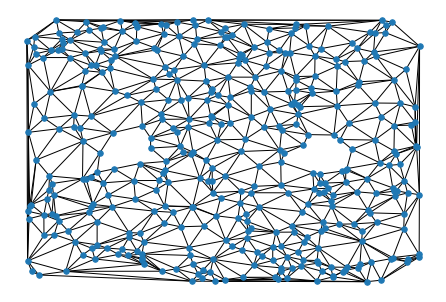

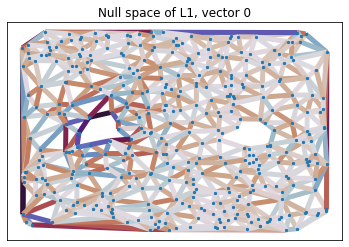

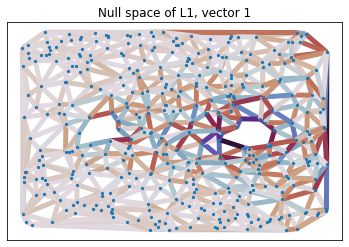

[-5.61383887e-16 -2.21220153e-16  1.48830816e-02]


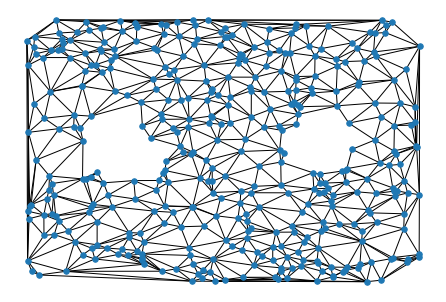

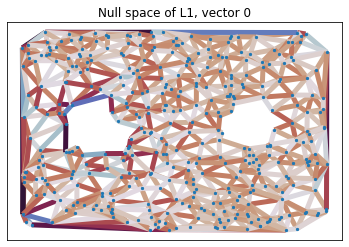

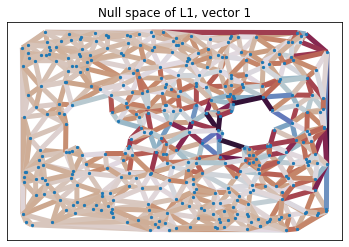

[-1.35525097e-16  1.29686610e-15  1.81097822e-02]


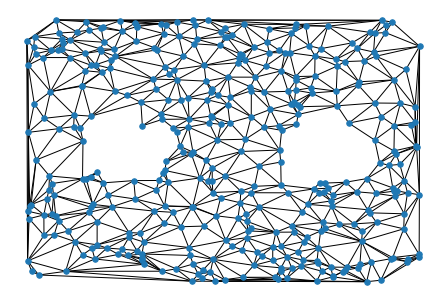

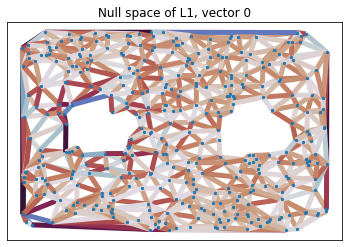

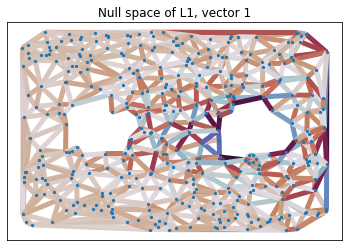

[-1.10911404e-15  2.01183299e-16  1.87928141e-02]


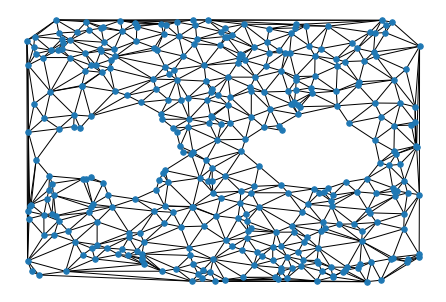

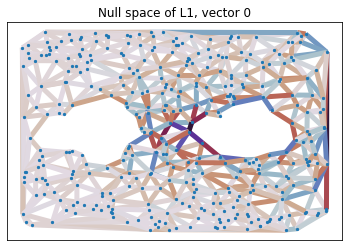

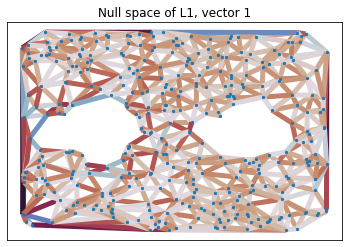

[-2.60627480e-16  2.62241400e-16  2.00772092e-02]


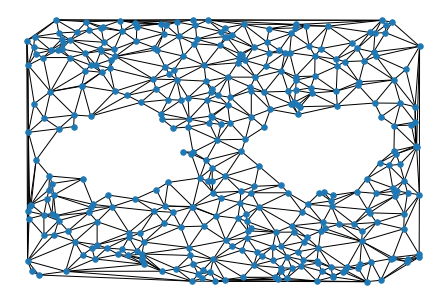

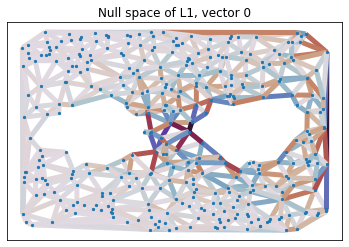

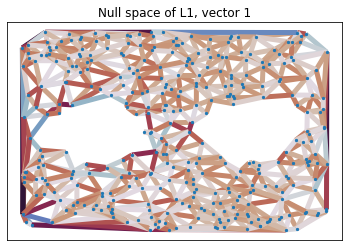

[-1.29352884e-15  8.41263941e-16  2.11095879e-02]


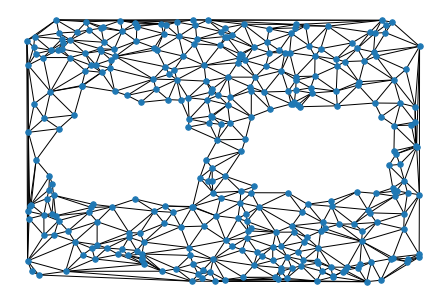

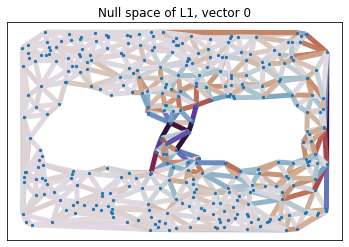

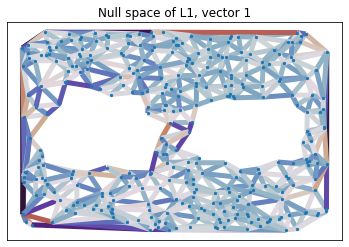

[1.08979180e-15 1.13474560e-15 2.49299495e-02]


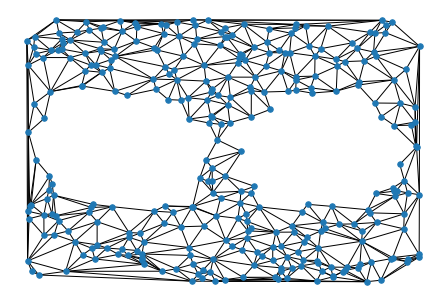

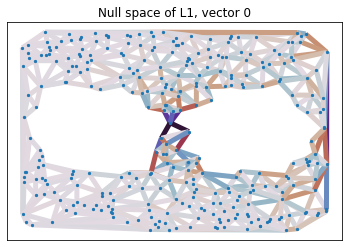

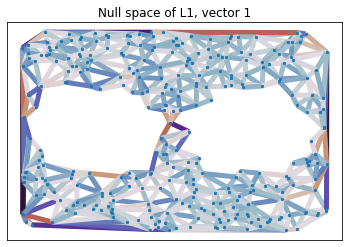

[-1.39223686e-15 -3.31902121e-16  2.71649624e-02]


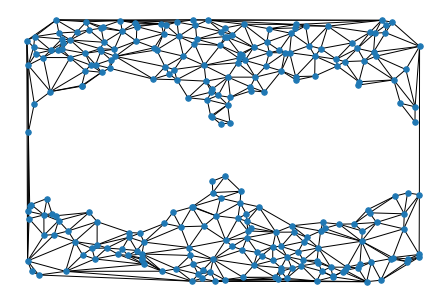

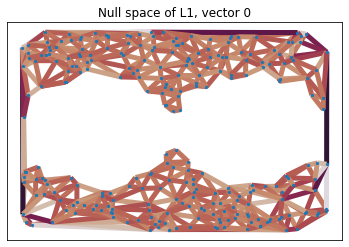

[-2.97917627e-15  2.13091440e-02  3.20250348e-02]


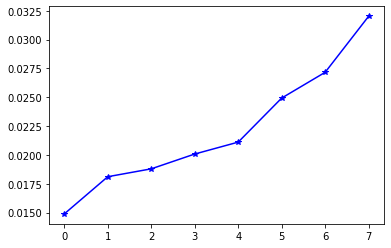

In [71]:
centre_holes = np.array([[0.25,0.5],[0.75,0.5]])
print(centre_holes.shape)
print(centre_holes)
n_points=400
x = np.random.rand(n_points)
y = np.random.rand(n_points)
points = np.vstack([x,y]).T
tri = Delaunay(points)

radii=[0.05,0.075,0.1,0.125,0.15,0.175,0.2]

Spectral_gap=np.zeros(len(radii))

for i,radius in enumerate(radii):
    graph, points = get_delauney_holes_static_multi(tri, centre_holes,radius)
    pos = dict(enumerate(points))
    nx.draw(graph,pos,node_size=30)

    KerL1,L1=Null_Space_Plot(graph)
    v,w=L1_spectrum(L1.todense())
    
    Spectral_gap[i]=w[2]
    
#     plt.figure()
#     plt.plot(w[:10],'b*')
#     plt.show()
plt.figure()
plt.plot(Spectral_gap,'b*-')
plt.show()

# Single hole size effect

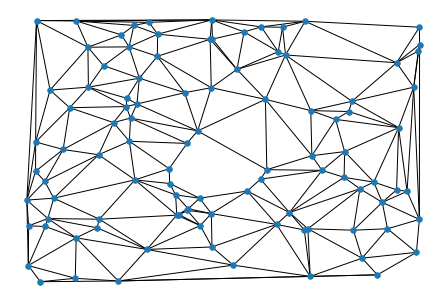

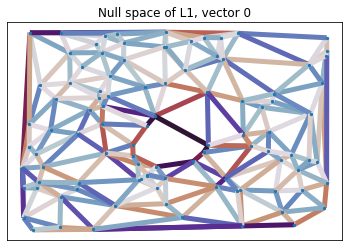

In [23]:
centre_holes = np.array([[0.5,0.5]])

radius = 0.05
n_points=100

graph, points = get_delauney_holes_multi(n_points,centre_holes,radius)
pos = dict(enumerate(points))
nx.draw(graph,pos,node_size=30)

KerL1,L1=Null_Space_Plot(graph)

Radius: 0.2


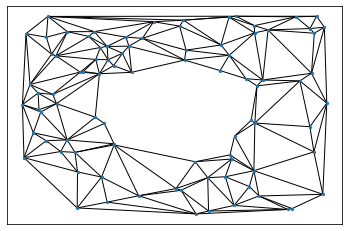

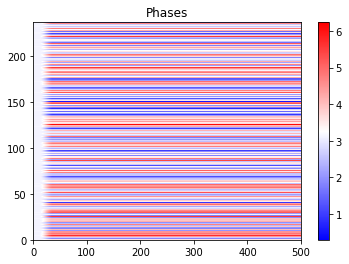

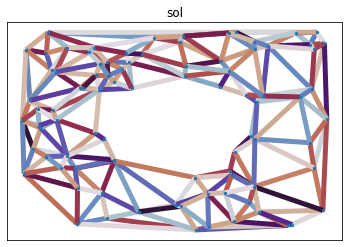

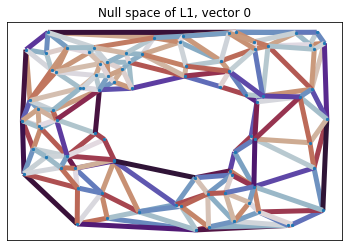

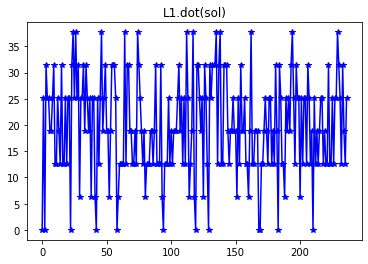

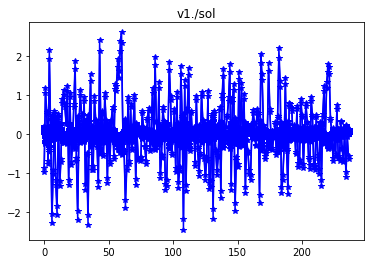

In [74]:
centre_hole = np.array([[0.5,0.5]])

n_points=100
x = np.random.rand(n_points)
y = np.random.rand(n_points)
points = np.vstack([x,y]).T

radii=[0.2]

for radius in radii:
    print('Radius: '+str(radius))
    graph, points = get_delauney_holes_multi(n_points,centre_hole, radius,points)
    pos = dict(enumerate(points))
#     nx.draw(graph,pos,node_size=30)

    plt.figure()
    nx.draw_networkx_nodes(graph, pos=points, node_size=5)
    nx.draw_networkx_edges(graph, pos=points)

    labels = dict(((u, v), d) for d, (u, v) in enumerate(graph.edges))

#     np.random.seed(0)
#     initial_phase = np.ones(len(graph.edges))*np.pi
    initial_phase = np.random.normal(np.pi,0.01,len(graph.edges))
#     initial_phase = np.random.uniform(np.pi/2, 3 * np.pi/2, len(graph.edges))

    t_max = 500
    n_t = 20

    complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)

    edge_result = integrate_edge_kuramoto(complex_delaunay, initial_phase, t_max, n_t)
    plotting.plot_edge_kuramoto(edge_result)
        # plt.savefig("phases_no_faces.png")

#     plotting.plot_order_parameter(edge_result.y, return_op=False, plot=True)

    plt.figure()
    nx.draw_networkx_nodes(graph, pos=points, node_size=5)
    nx.draw_networkx_edges(
            graph,
            pos=points,
            edge_color=edge_result.y[:, -1],
            edge_cmap=plt.get_cmap("twilight_shifted"),
            width=5,
            edge_vmin=np.min(edge_result.y),
            edge_vmax=np.max(edge_result.y),
        )
    plt.title('sol')
    plt.show()

    KerL1,L1=Null_Space_Plot(graph) # getting the null space and L1
#     print(np.divide(KerL1.T,edge_result.y[:, -1]))
    plt.figure()
    plt.plot(L1.dot(edge_result.y[:, -1]),'b*-') #that should be 0 elementwise
    plt.title('L1.dot(sol)')
    plt.show()
    
    plt.figure()
    plt.plot(np.divide(KerL1,edge_result.y[:, -1]),'b*-') # that should be a constant
    plt.title('v1./sol')
    plt.show()
    

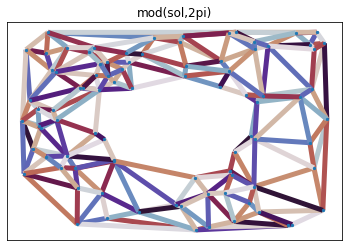

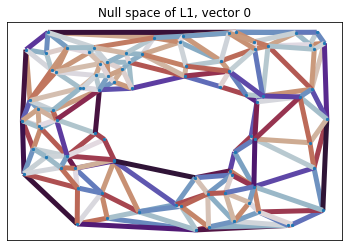

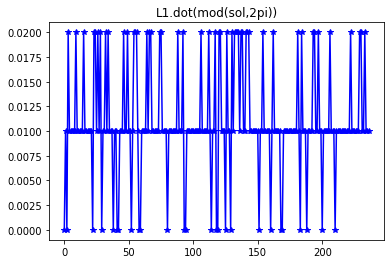

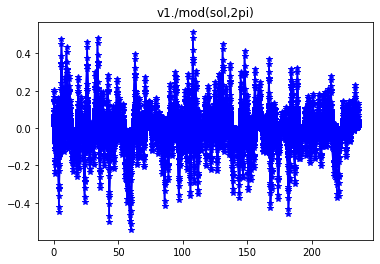

In [75]:
precision=2
# plotting.plot_edge_kuramoto(np.mod(np.around(edge_result.y, precision), np.around(2 * np.pi, precision)))

plt.figure()
nx.draw_networkx_nodes(graph, pos=points, node_size=5)
nx.draw_networkx_edges(
        graph,
        pos=points,
        edge_color=np.mod(np.around(edge_result.y[:,-1], precision), np.around(2 * np.pi, precision)),
        edge_cmap=plt.get_cmap("twilight_shifted"),
        width=5,
        edge_vmin=np.min(np.mod(np.around(edge_result.y[:,-1], precision), np.around(2 * np.pi, precision))),
        edge_vmax=np.max(np.mod(np.around(edge_result.y[:,-1], precision), np.around(2 * np.pi, precision))),
    )
plt.title('mod(sol,2pi)')
plt.show()

KerL1,L1=Null_Space_Plot(graph) # getting the null space and L1
#     print(np.divide(KerL1.T,edge_result.y[:, -1]))
plt.figure()
plt.plot(np.mod(np.around(L1.dot(edge_result.y[:,-1]), precision), np.around(2 * np.pi, precision)),'b*-') #that should be 0 elementwise
plt.title('L1.dot(mod(sol,2pi))')
plt.show()

plt.figure()
plt.plot(np.divide(KerL1,np.mod(np.around(edge_result.y[:,-1], precision), np.around(2 * np.pi, precision))),'b*-') # that should be a constant
plt.title('v1./mod(sol,2pi)')
plt.show()

(237, 20)


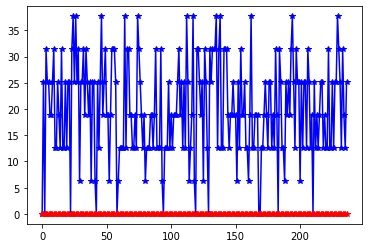

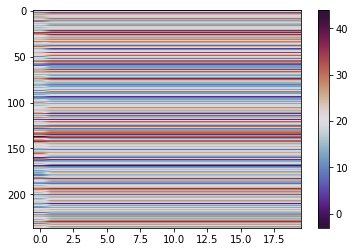

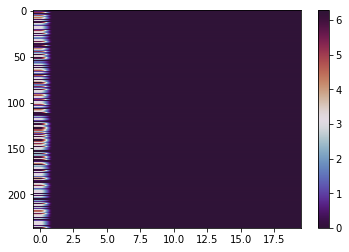

In [76]:
print(edge_result.y.shape)
precision=2
plt.figure()
plt.plot(L1.dot(edge_result.y[:,-1]),'b*-') #that should be 0 elementwise
plt.plot(np.mod(np.around(L1.dot(edge_result.y[:, -1]), precision), np.around(2 * np.pi, precision)),'r*-') #that should be 0 elementwise
plt.show()
plt.figure()
plt.imshow(L1.dot(edge_result.y),aspect="auto",cmap="twilight_shifted",) #that should be 0 elementwise
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(np.mod(np.around(L1.dot(edge_result.y), precision), np.around(2 * np.pi, precision)),aspect="auto",cmap="twilight_shifted",) #that should be 0 elementwise
plt.colorbar()
plt.show()

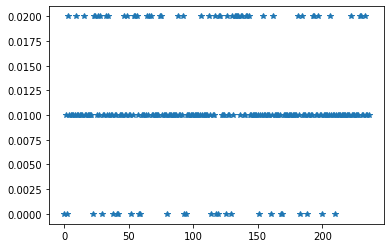

[0.   0.01 0.   0.02 0.01 0.01 0.01 0.01 0.01 0.02 0.01 0.01 0.01 0.01
 0.01 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.02 0.02 0.01 0.02 0.01
 0.02 0.   0.01 0.01 0.02 0.01 0.02 0.01 0.01 0.01 0.   0.01 0.01 0.
 0.   0.01 0.01 0.01 0.02 0.01 0.01 0.02 0.01 0.01 0.   0.01 0.02 0.02
 0.02 0.01 0.   0.   0.01 0.01 0.01 0.01 0.02 0.01 0.02 0.02 0.01 0.01
 0.01 0.01 0.01 0.01 0.02 0.02 0.01 0.01 0.01 0.01 0.   0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.02 0.01 0.01 0.01 0.02 0.   0.   0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.01 0.01 0.01 0.01 0.01
 0.02 0.01 0.   0.01 0.01 0.02 0.   0.   0.02 0.02 0.01 0.01 0.01 0.
 0.02 0.01 0.01 0.   0.02 0.01 0.02 0.02 0.02 0.02 0.01 0.02 0.02 0.01
 0.01 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.01 0.01
 0.02 0.01 0.01 0.01 0.01 0.01 0.   0.01 0.02 0.01 0.01 0.01 0.01 0.01
 0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02
 0.01 0.   0.02 0.01 0.01 0.01 0.   0.01 0.01 0.01 0.01 0.02 0.02 0.01
 0.01 0.02

In [77]:
plt.figure()
plt.plot(np.mod(np.around(L1.dot(edge_result.y[:, -1]), precision), np.around(2 * np.pi, precision)),'*')
plt.show()
print(np.mod(np.around(L1.dot(edge_result.y[:, -1]), precision), np.around(2 * np.pi, precision)))